# Suitability
Brian Li \
11/04/23

This notebook contains suitability analysis of the occupation of electrician as defined by the BLS.

The data were sourced from the Bureau of Labor Statistics' Occupational Outlook Handbook.

The East Coast and Great Lakes regions have areas of high employment for electricians.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
bls = pd.read_excel("https://github.com/ugin331/GGIS-371/raw/bd44c226b080655bb6705388db7c8d11d6178f81/OES_Report.xlsx", skiprows=5)
bls["msa7"] = bls["Area Name"].str.extract(r'(\d{7})')
bls = bls[["msa7", "Area Name", "Employment(1)", "Annual median wage(2)", "Employment per 1,000 jobs", "Location Quotient"]]
bls.columns = ["msa7", "msa_name", "employment", "mean_wage", "employment_per_1k", "location_quotient"]
for column in ["employment", "mean_wage", "employment_per_1k", "location_quotient"]: bls[column] = pd.to_numeric(bls[column], errors="coerce")
bls = bls.dropna()
bls = bls.sort_values("employment", ascending=False).reset_index(drop=True)
bls[["msa_name", "employment"]].head()

,msa_name,employment
0,"New York-Newark-Jersey City, NY-NJ-PA(0035620)",38760.0
1,"Los Angeles-Long Beach-Anaheim, CA(0031080)",20870.0
2,"Houston-The Woodlands-Sugar Land, TX(0026420)",18160.0
3,"Dallas-Fort Worth-Arlington, TX(0019100)",17600.0
4,"Chicago-Naperville-Elgin, IL-IN-WI(0016980)",14960.0


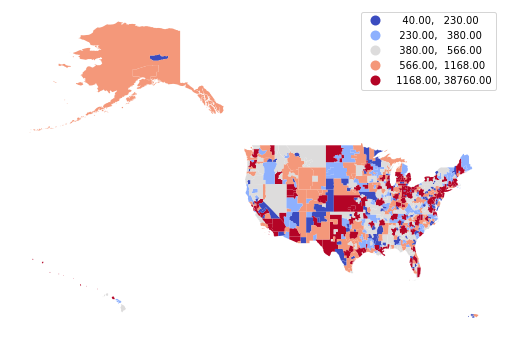

In [5]:
plt.rcParams['figure.figsize'] = [9, 6]
msa = gpd.read_file("https://michaelminn.net/tutorials/python-suitability/2019-msashape2.zip")
msa["msa7"] = msa["msa7"].str.zfill(7)
bls_msa = msa.merge(bls, on="msa7")
axis = bls_msa.plot("employment", cmap="coolwarm", legend=True, scheme="quantiles")
axis.set_axis_off()
plt.show()

a. The housing data were sourced from the US Census Bureau's American Community Survey via Michael Minn.

b. "This code creates an affordability index where an index of 100 indicates the normal percentage of income going to housing, values above 100 reflect affordability better than normal across the US, and values below 100 reflect lower affordability than normal" (https://michaelminn.net/tutorials/python-suitability/).

c. The Rust Belt is an area of relatively high housing affordability for electricians.

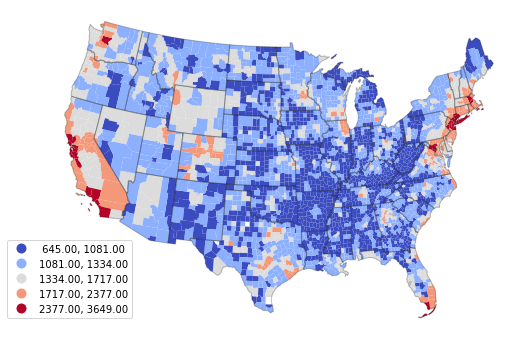

In [7]:
counties = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-counties.geojson")
counties = counties[~counties["ST"].isin(['AK', 'HI', 'PR'])]
counties = counties[["Name", "ST", "FactFinder GEOID", "Median Monthly Mortgage", "geometry"]]
counties = counties.to_crs("ESRI:102008")
states = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-states.geojson")
states = states[~states["ST"].isin(['AK', 'HI', 'PR'])]
states = states.to_crs(counties.crs)
axis = counties.plot("Median Monthly Mortgage", cmap="coolwarm",
    legend=True, scheme="naturalbreaks",
    legend_kwds={"bbox_to_anchor":(0.2, 0.3)})
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

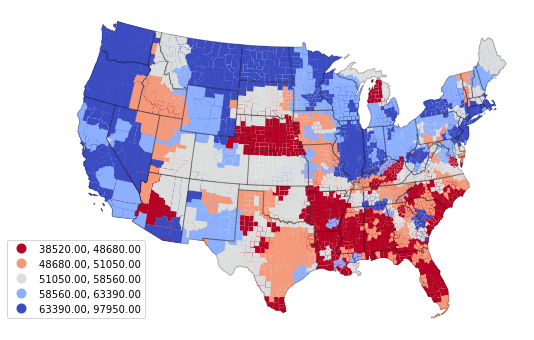

In [8]:
bls_msa = bls_msa.to_crs(counties.crs)
bls_counties = counties[["FactFinder GEOID", "Name", "ST", "Median Monthly Mortgage", "geometry"]]
bls_counties = bls_counties.sjoin(bls_msa, how="left")
bls_counties = bls_counties.drop("index_right", axis=1)
axis = bls_counties.plot("mean_wage", cmap="coolwarm_r", 
    legend=True, scheme="quantiles",
    legend_kwds={"bbox_to_anchor":(0.2, 0.3)})
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

In [9]:
bls_counties["affordability"] = 100 * (bls_counties["mean_wage"] * 0.29) / (bls_counties["Median Monthly Mortgage"] * 12)
bls_counties = bls_counties.dropna()
bls_counties = bls_counties.sort_values("affordability", ascending=False).reset_index(drop=True)
bls_counties[["Name", "ST", "affordability"]].head()

,Name,ST,affordability
0,Pulaski,IN,249.171053
1,White,IN,247.607218
2,Benton,IN,246.575521
3,Starke,IN,238.621472
4,Newton,IN,225.870706


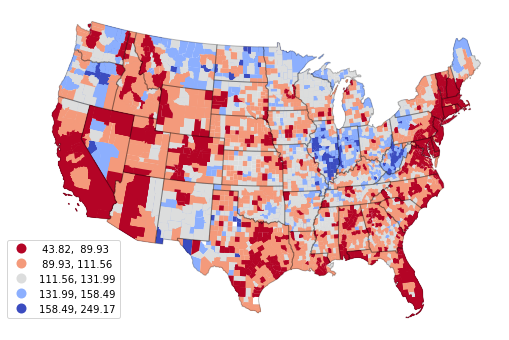

In [10]:
axis = bls_counties.plot("affordability", cmap="coolwarm_r",
    legend=True, scheme="naturalbreaks",
    legend_kwds={"bbox_to_anchor":(0.2, 0.3)})
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

My points of interest are some major cities in the US.

The East and West Coasts are favored by my points of interest.

In [11]:
cities = [ ["San Francisco", 37.7775, -122.416389],
    ["Seattle", 47.609722, -122.333056],
    ["New York City", 40.712778, -74.006111],
    ["Chicago", 41.881944, -87.627778],
    ["Greater Washington", 38.89, -77.046667] ]
cities = pd.DataFrame(cities, columns=["City", "Latitude", "Longitude"])
geometry = gpd.points_from_xy(cities["Longitude"], cities["Latitude"])
cities = gpd.GeoDataFrame(cities, geometry = geometry, crs="EPSG:4326")
cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   City       5 non-null      object  
 1   Latitude   5 non-null      float64 
 2   Longitude  5 non-null      float64 
 3   geometry   5 non-null      geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 288.0+ bytes


In [12]:
cities = cities.to_crs(bls_counties.crs)
bls_counties = bls_counties.sjoin_nearest(cities, how="left", distance_col="city_distance")
bls_counties["city_distance"] = bls_counties["city_distance"] / 1000
bls_counties = bls_counties.drop_duplicates("FactFinder GEOID")
bls_counties = bls_counties.drop("index_right", axis=1)
bls_counties = bls_counties.sort_values("city_distance").reset_index(drop=True)
bls_counties[["Name", "ST", "city_distance"]].head()

,Name,ST,city_distance
0,Cook,IL,0.000000
1,King,WA,0.000000
2,Kings,NY,0.000000
3,San Francisco,CA,0.000000
4,New York,NY,1.006115


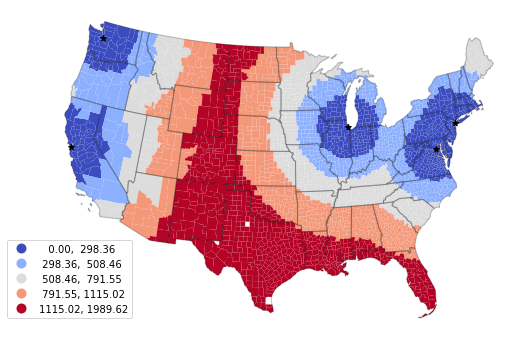

In [14]:
axis = bls_counties.plot("city_distance", cmap="coolwarm",
    legend=True, scheme="quantiles",
    legend_kwds={"bbox_to_anchor":(0.2, 0.3)})
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
cities.plot(marker="*", color="black", ax=axis)
axis.set_axis_off()
plt.show()

"Categorical suitability analysis involves the selection of areas based on satisfaction of specific categorical conditions, usually involving thresholds for quantitative values" (https://michaelminn.net/tutorials/python-suitability/).

I would seriously consider living in Pierce County, WA, which is right next to Seattle in the Seattle-Tacoma metropolitan statistical area.

Pierce County was named after Franklin Pierce, 14th President of the US.

Pierce County is surprisingly affordable considered it's a part of a major metropolitan region, being right next to Seattle.

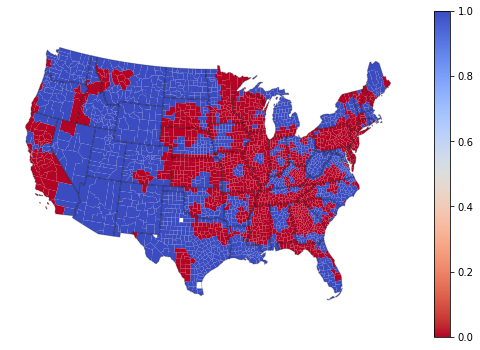

In [16]:
bls_counties["Suitable Employment"] = (bls_counties["location_quotient"] >= 1)
axis = bls_counties.plot("Suitable Employment", cmap="coolwarm_r", legend=True)
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

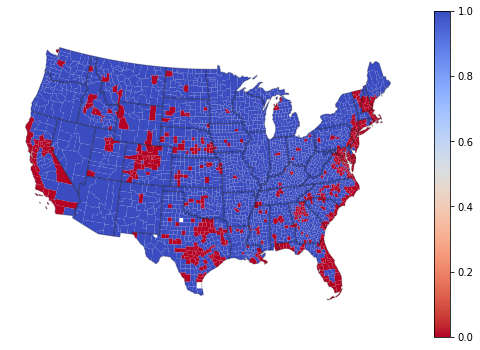

In [17]:
bls_counties["Suitable Housing"] = (bls_counties["affordability"] >= 100)
axis = bls_counties.plot("Suitable Housing", cmap="coolwarm_r", legend=True)
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

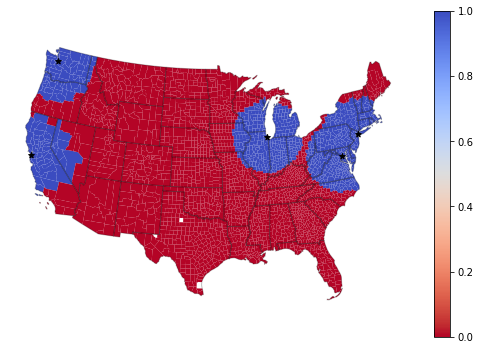

In [18]:
bls_counties["Suitable Cities"] = (bls_counties["city_distance"] < 400)
axis = bls_counties.plot("Suitable Cities", cmap="coolwarm_r", legend=True)
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
cities.plot(marker="*", color="black", ax=axis)
axis.set_axis_off()
plt.show()

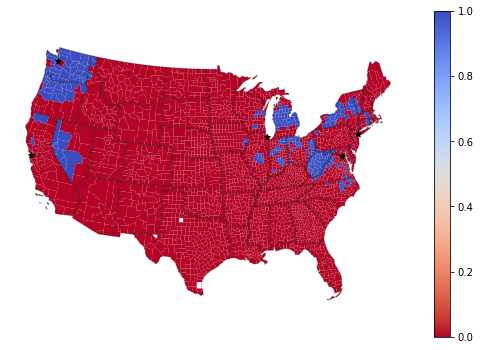

In [19]:
bls_counties["Categorical Suitability"] = bls_counties["Suitable Employment"] & \
                bls_counties["Suitable Housing"] & bls_counties["Suitable Cities"]
axis = bls_counties.plot("Categorical Suitability", cmap="coolwarm_r",
        legend=True)
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
cities.plot(marker="*", color="black", ax=axis)
axis.set_axis_off()
plt.show()

In [21]:
list_counties = bls_counties[bls_counties["Categorical Suitability"]]
list_counties[["Name", "ST"]]

,Name,ST
12,Kitsap,WA
25,Snohomish,WA
32,Island,WA
35,Pierce,WA
41,Jefferson,WA
...,...,...
923,Oscoda,MI
927,Boundary,ID
928,Richland,OH
931,Genesee,NY


"Weighted suitability analysis involves the creation of a linear model that is a weighted sum of the different criteria" (https://michaelminn.net/tutorials/python-suitability/).

I weighted indices 0.4 0.2 0.4 for employment, affordability, and desirable cities respectively, because I think employment near somewhere you like living is more important than affordability, which comes second.

I would pick Ocean County, NJ, which is on the coast near NYC.

Ocean County is 31% water.

Ocean County is close to NYC which is probably good for employment and such.

In [22]:
bls_counties["employment_index"] = (bls_counties["employment"] - min(bls_counties["employment"])) / \
    (max(bls_counties["employment"]) - min(bls_counties["employment"]))
bls_counties["affordability_index"] = (bls_counties["affordability"] - min(bls_counties["affordability"])) / \
    (max(bls_counties["affordability"]) - min(bls_counties["affordability"]))
bls_counties["city_index"] = (max(bls_counties["city_distance"]) - bls_counties["city_distance"]) / \
    (max(bls_counties["city_distance"]) - min(bls_counties["city_distance"]))

bls_counties[["employment_index", "affordability_index", "city_index"]].head()

,employment_index,affordability_index,city_index
0,0.385331,0.381332,1.000000
1,0.258781,0.190881,1.000000
2,1.000000,0.095244,1.000000
3,0.256973,0.054266,1.000000
4,1.000000,0.054290,0.999494


In [23]:
bls_counties["Weighted Suitability"] = (0.4 * bls_counties["employment_index"]) + \
    (0.2 * bls_counties["affordability_index"]) + \
    (0.4 * bls_counties["city_index"])
bls_counties = bls_counties.sort_values("Weighted Suitability", ascending=False).reset_index(drop=True)
bls_counties[["Name", "ST", "Weighted Suitability"]].head()

,Name,ST,Weighted Suitability
0,Pike,PA,0.854102
1,Sullivan,NY,0.850930
2,Monroe,PA,0.846179
3,Columbia,NY,0.832530
4,Ocean,NJ,0.832259


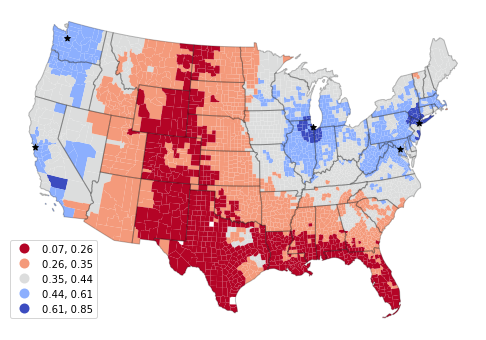

In [24]:
axis = bls_counties.plot("Weighted Suitability", cmap="coolwarm_r",
    legend=True, scheme="naturalbreaks",
    legend_kwds={"bbox_to_anchor":(0.2, 0.3)})
states.plot(edgecolor="#00000040", facecolor="none", ax=axis)
cities.plot(marker="*", color="black", ax=axis)
axis.set_axis_off()
plt.show()